In [12]:
import pandas as pd

In [13]:
data = pd.read_csv('../Data/epsPQRS.csv', sep=';')
data

,Comentario,Area
0,pqrd-18-0674823nurc 1-2018-221502entidad: capi...,Negación De Servicios
1,pqrd-18-0675272nurc 1-2018-216612entidad: capi...,Negación De Servicios
2,pqrd-18-0675410nurc 1-2018-221583entidad: capi...,Dificultad Accesibilidad Administrativa
3,pqrd-18-0675530nurc 1-2018-217812entidad: capi...,Negación De Servicios
4,favor enviar copia al ministerio de salud y pr...,Dificultad Tutelas
...,...,...
82773,apixaban 5 mg tableta,Otro
82774,ss solucion mipres 20201123175024488426,Negación De ServiciosDificultad MédicoAdmin
82775,ss implante de dispositivo en cornea asistido,Negación De ServiciosDificultad MédicoAdmin
82776,ss control hepatologia ips fundacion santa fe,Negación De ServiciosDificultad MédicoAdmin


In [14]:
data = data.sample(frac=0.2)

In [15]:
data.Area.value_counts(normalize=True)

Oportunidad Citas Red Contratada                  0.443404
No Suministro Medicamentos                        0.188572
Dificultad Accesibilidad Administrativa           0.117661
Inconsistencias Sistemas De InformacionAsegura    0.079488
Negación De ServiciosDificultad MédicoAdmin       0.055025
Dificultad Tutelas                                0.026154
Negación De Servicios                             0.025912
Otro                                              0.019026
Incumplimiento Portabilidad Nacional              0.010027
Problemas Recursos Economicos                     0.005859
Atención Deshumanizada                            0.005194
Prestaciones Economicas                           0.005134
Tramite Interno I                                 0.005074
Dificultad Alto Costo                             0.005074
Cotizaciones Pau Rs                               0.004651
Exclusiones Usuarios Sin Tutela                   0.003745
Name: Area, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=0)

In [17]:
print(f'Tenemos {data.shape[0]} datos en total.')
print(f'El conjunto de entrenamiento (train) tiene {train.shape[0]} datos.')
print(f'El conjunto de prueba (test) tiene {test.shape[0]} datos.')

Tenemos 16556 datos en total.
El conjunto de entrenamiento (train) tiene 11589 datos.
El conjunto de prueba (test) tiene 4967 datos.


In [18]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_sp = stopwords.words('spanish')

In [19]:
stopwords_sp.extend(["pqrd", "entidad", "nurc", "dia", "capital", "salud","bogotá"])
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [20]:
X_train = tfidf_vect.fit_transform(train.Comentario.values)
y_train = train.Area.values

In [21]:
X_test = tfidf_vect.transform(test.Comentario.values)
y_test = test.Area.values

In [22]:
print(f"Tamaño de X_train (entrenamiento): {pd.DataFrame(X_train.toarray()).shape}")
print(f"Tamaño de X_test (prueba): {pd.DataFrame(X_test.toarray()).shape}")
print(f"Tamaño de y_train {len(y_train)} y tamaño de y_test {len(y_test)}")

Tamaño de X_train (entrenamiento): (11589, 21831)
Tamaño de X_test (prueba): (4967, 21831)
Tamaño de y_train 11589 y tamaño de y_test 4967


# Modelos

In [23]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [24]:
solicitud = ['diagnóstico posible derrame interno se encuentra hospitalizado en la ips hospital de san jorge',
             'Tengo mucho dolor de cabeza y necesito atencion', 
             'Estoy solicitando una cita desde hace mucho tiempo']
solicitud_trans = tfidf_vect.transform(solicitud)

# Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [26]:
nb.fit(X_train, y_train)

MultinomialNB()

In [27]:
y_pred_nb = nb.predict(X_test)

In [28]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_nb):>15.2f}')

Exactitud:            0.56


In [29]:
print(classification_report(y_test, y_pred_nb))

                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.00      0.00      0.00        29
                           Cotizaciones Pau Rs       0.00      0.00      0.00        16
       Dificultad Accesibilidad Administrativa       0.72      0.27      0.40       602
                         Dificultad Alto Costo       0.00      0.00      0.00        27
                            Dificultad Tutelas       0.00      0.00      0.00       133
               Exclusiones Usuarios Sin Tutela       0.00      0.00      0.00        27
Inconsistencias Sistemas De InformacionAsegura       0.91      0.10      0.18       399
          Incumplimiento Portabilidad Nacional       0.00      0.00      0.00        52
                         Negación De Servicios       0.00      0.00      0.00       122
   Negación De ServiciosDificultad MédicoAdmin       0.00      0.00      0.00       278
                    No Suminist

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


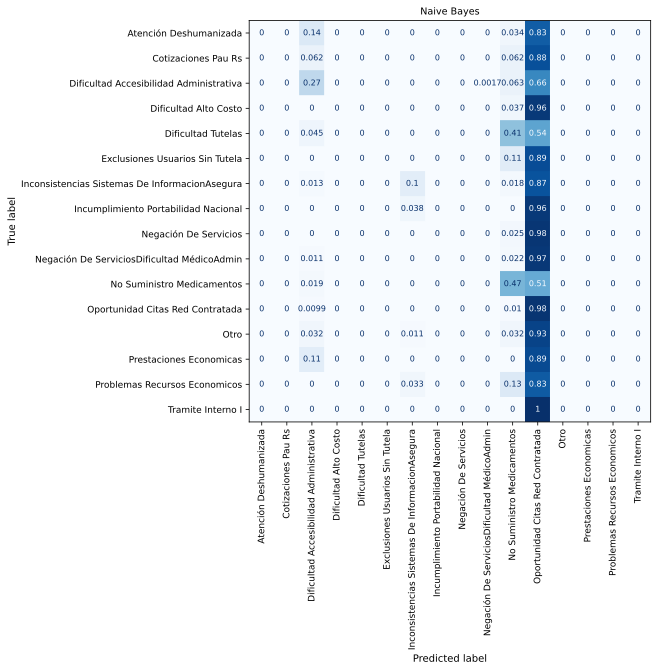

In [30]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (9, 9))

# Set general font size
plt.rcParams['font.size'] = '8'

plot_confusion_matrix(nb, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Naive Bayes")
plt.show()

In [31]:
print(nb.predict(solicitud_trans))

['Oportunidad Citas Red Contratada' 'Oportunidad Citas Red Contratada'
 'Oportunidad Citas Red Contratada']


# Regresión Logística

In [32]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')

In [33]:
logreg.fit(X_train, y_train)

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [34]:
y_pred_logreg = logreg.predict(X_test)

In [35]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_logreg):>15.2f}')

Exactitud:            0.62


In [36]:
print(classification_report(y_test, y_pred_logreg))

                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.26      0.45      0.33        29
                           Cotizaciones Pau Rs       0.00      0.00      0.00        16
       Dificultad Accesibilidad Administrativa       0.57      0.38      0.46       602
                         Dificultad Alto Costo       0.20      0.41      0.27        27
                            Dificultad Tutelas       0.23      0.47      0.31       133
               Exclusiones Usuarios Sin Tutela       0.14      0.19      0.16        27
Inconsistencias Sistemas De InformacionAsegura       0.64      0.68      0.66       399
          Incumplimiento Portabilidad Nacional       0.57      0.62      0.59        52
                         Negación De Servicios       0.23      0.48      0.32       122
   Negación De ServiciosDificultad MédicoAdmin       0.35      0.51      0.42       278
                    No Suminist

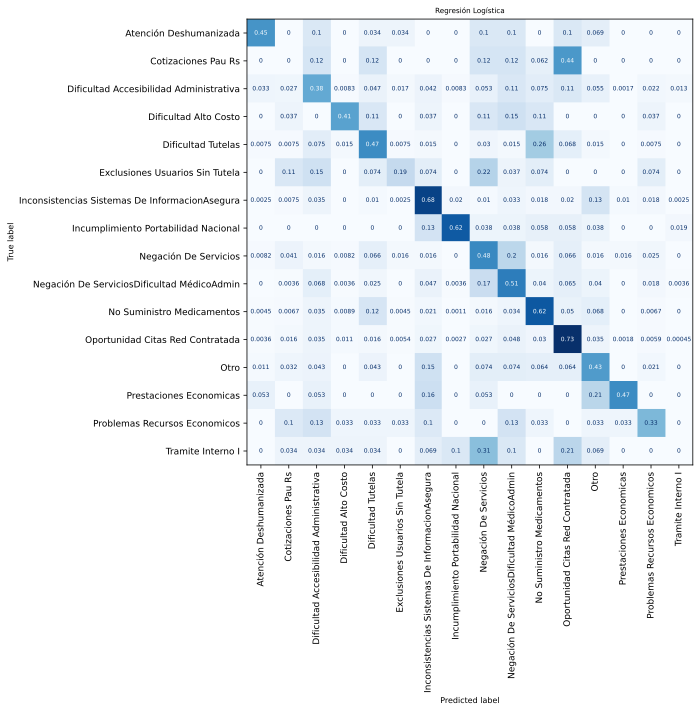

In [37]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(logreg, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Regresión Logística")
plt.show()

In [38]:
print(logreg.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin' 'Atención Deshumanizada'
 'Oportunidad Citas Red Contratada']


# Árbol de decisión

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced')

In [40]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [41]:
y_pred_dt = dt.predict(X_test)

In [42]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_dt):>15.2f}')

Exactitud:            0.53


In [43]:
print(classification_report(y_test, y_pred_dt))

                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.20      0.28      0.23        29
                           Cotizaciones Pau Rs       0.00      0.00      0.00        16
       Dificultad Accesibilidad Administrativa       0.41      0.38      0.40       602
                         Dificultad Alto Costo       0.07      0.11      0.09        27
                            Dificultad Tutelas       0.18      0.18      0.18       133
               Exclusiones Usuarios Sin Tutela       0.16      0.19      0.17        27
Inconsistencias Sistemas De InformacionAsegura       0.55      0.46      0.50       399
          Incumplimiento Portabilidad Nacional       0.56      0.54      0.55        52
                         Negación De Servicios       0.13      0.16      0.14       122
   Negación De ServiciosDificultad MédicoAdmin       0.27      0.27      0.27       278
                    No Suminist

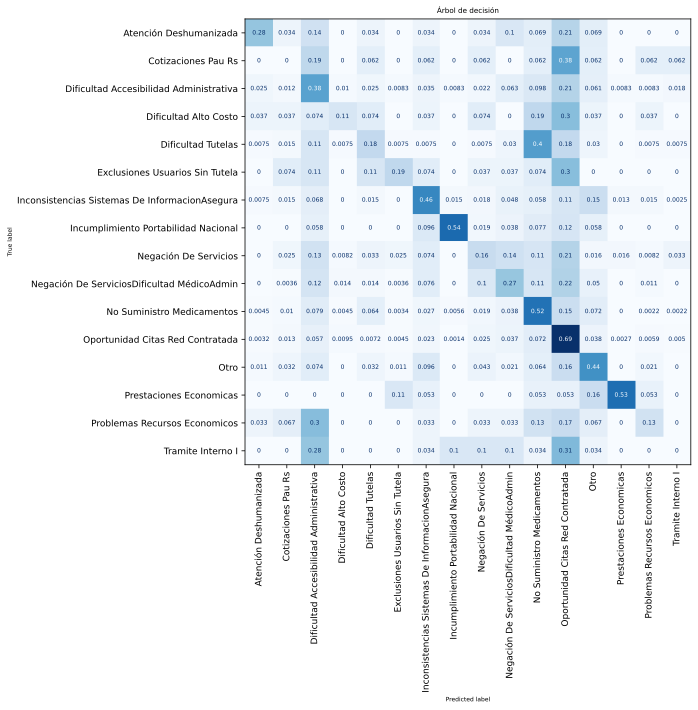

In [44]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(dt, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Árbol de decisión")
plt.show()

In [45]:
print(dt.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Negación De ServiciosDificultad MédicoAdmin'
 'Oportunidad Citas Red Contratada']


# Red Neuronal

In [46]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, activation='logistic', max_iter=100,hidden_layer_sizes=(2,3), random_state=1)

In [47]:
clf.fit(X_train, y_train)

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=1e-05, hidden_layer_sizes=(2, 3),
              max_iter=100, random_state=1)

In [48]:
y_pred_clf = clf.predict(X_test)

In [49]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_clf):>15.2f}')

Exactitud:            0.55


In [50]:
print(classification_report(y_test, y_pred_clf))

                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.00      0.00      0.00        29
                           Cotizaciones Pau Rs       0.00      0.00      0.00        16
       Dificultad Accesibilidad Administrativa       0.44      0.07      0.12       602
                         Dificultad Alto Costo       0.00      0.00      0.00        27
                            Dificultad Tutelas       0.00      0.00      0.00       133
               Exclusiones Usuarios Sin Tutela       0.00      0.00      0.00        27
Inconsistencias Sistemas De InformacionAsegura       0.00      0.00      0.00       399
          Incumplimiento Portabilidad Nacional       0.00      0.00      0.00        52
                         Negación De Servicios       0.00      0.00      0.00       122
   Negación De ServiciosDificultad MédicoAdmin       0.00      0.00      0.00       278
                    No Suminist

C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrm20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


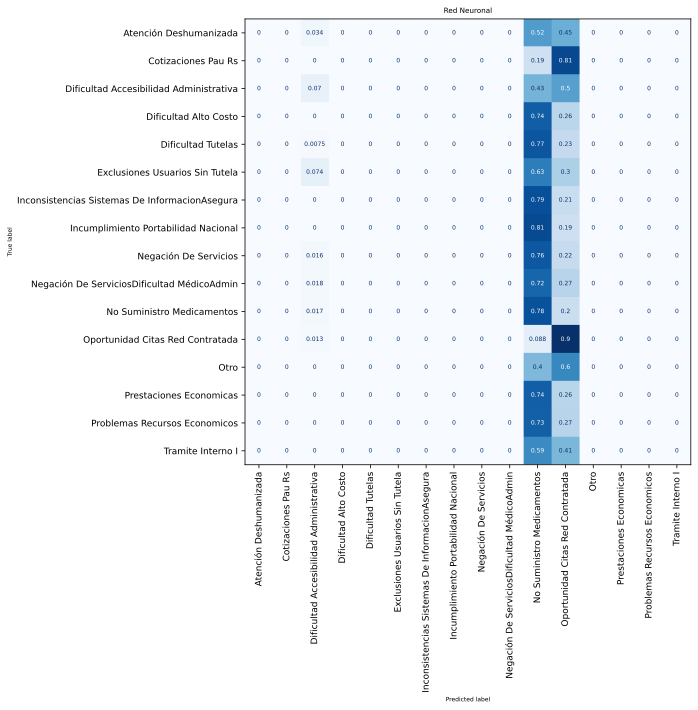

In [51]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(clf, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("Red Neuronal")
plt.show()

In [52]:
clf.predict(solicitud_trans)

array(['No Suministro Medicamentos',
       'Dificultad Accesibilidad Administrativa',
       'Oportunidad Citas Red Contratada'], dtype='<U46')

# SVM

In [53]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced')

In [54]:
svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [55]:
y_pred_svm = svm.predict(X_test)

In [56]:
print( f'Exactitud: {accuracy_score(y_test, y_pred_svm):>15.2f}')

Exactitud:            0.66


In [57]:
print(classification_report(y_test, y_pred_svm))

                                                precision    recall  f1-score   support

                        Atención Deshumanizada       0.37      0.34      0.36        29
                           Cotizaciones Pau Rs       0.00      0.00      0.00        16
       Dificultad Accesibilidad Administrativa       0.55      0.43      0.48       602
                         Dificultad Alto Costo       0.10      0.07      0.09        27
                            Dificultad Tutelas       0.21      0.24      0.23       133
               Exclusiones Usuarios Sin Tutela       0.12      0.11      0.12        27
Inconsistencias Sistemas De InformacionAsegura       0.69      0.67      0.68       399
          Incumplimiento Portabilidad Nacional       0.71      0.58      0.64        52
                         Negación De Servicios       0.28      0.34      0.31       122
   Negación De ServiciosDificultad MédicoAdmin       0.41      0.46      0.43       278
                    No Suminist

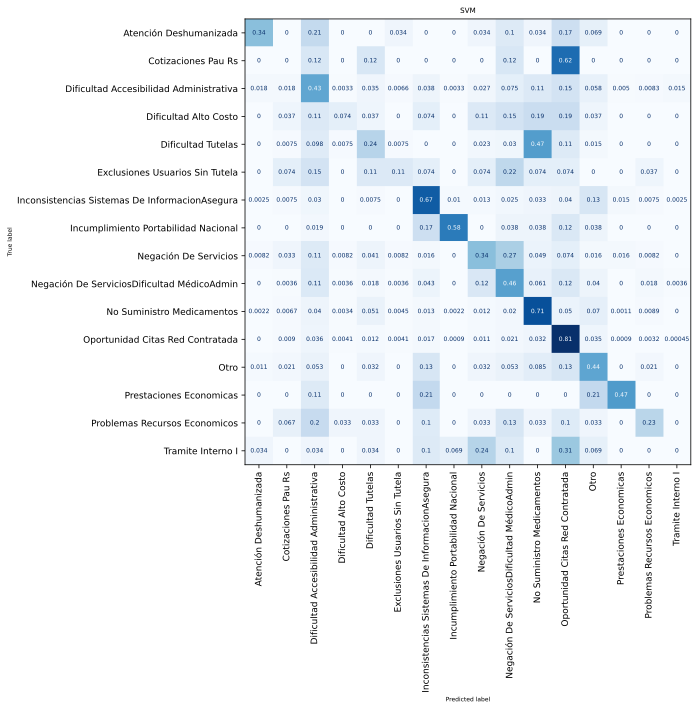

In [58]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots(figsize = (10, 10))

# Set general font size
plt.rcParams['font.size'] = '6'

plot_confusion_matrix(svm, X_test, y_test, cmap="Blues", ax=ax, normalize='true').im_.colorbar.remove()
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.title("SVM")
plt.show()

In [59]:
print(svm.predict(solicitud_trans))

['Negación De ServiciosDificultad MédicoAdmin'
 'Dificultad Accesibilidad Administrativa'
 'Oportunidad Citas Red Contratada']
